Bibliotecas importadas com sucesso!
--------------------------------------------------
Três datasets (Players, player_data, Seasons_Stats) carregados com sucesso!

3. JUNÇÃO DOS DATASETS
* Tamanho do DataFrame final após merge: (25297, 67)
* Colunas do DataFrame final:
['Unnamed: 0_season', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER']

4. INSPEÇÃO INICIAL

* Primeiras 5 linhas do DataFrame final:
   Unnamed: 0_season    Year           Player  Pos   Age   Tm     G  GS  MP  PER    TS%  3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  blanl  OWS  DWS   WS  WS/48  blank2  OBPM  DBPM  BPM  VORP     FG    FGA    FG%  3P  3PA  3P%     2P    2PA    2P%   eFG%     FT    FTA    FT%  ORB  DRB  TRB    AST  STL  BLK  TOV     PF    PTS  Unnamed: 0_player  height_x  weight_x                          collage    born birth_city birth_state  year_start  year_end position height_y  weight_y        birth_date                          college
0                  0  1950.0  Curly

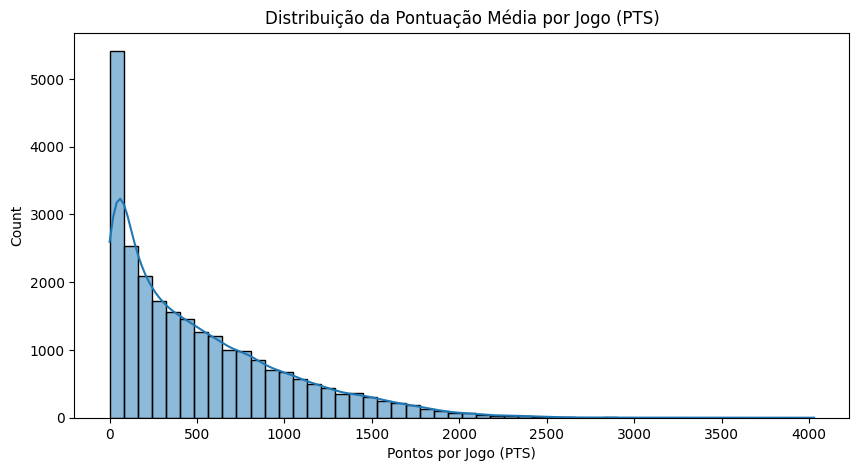

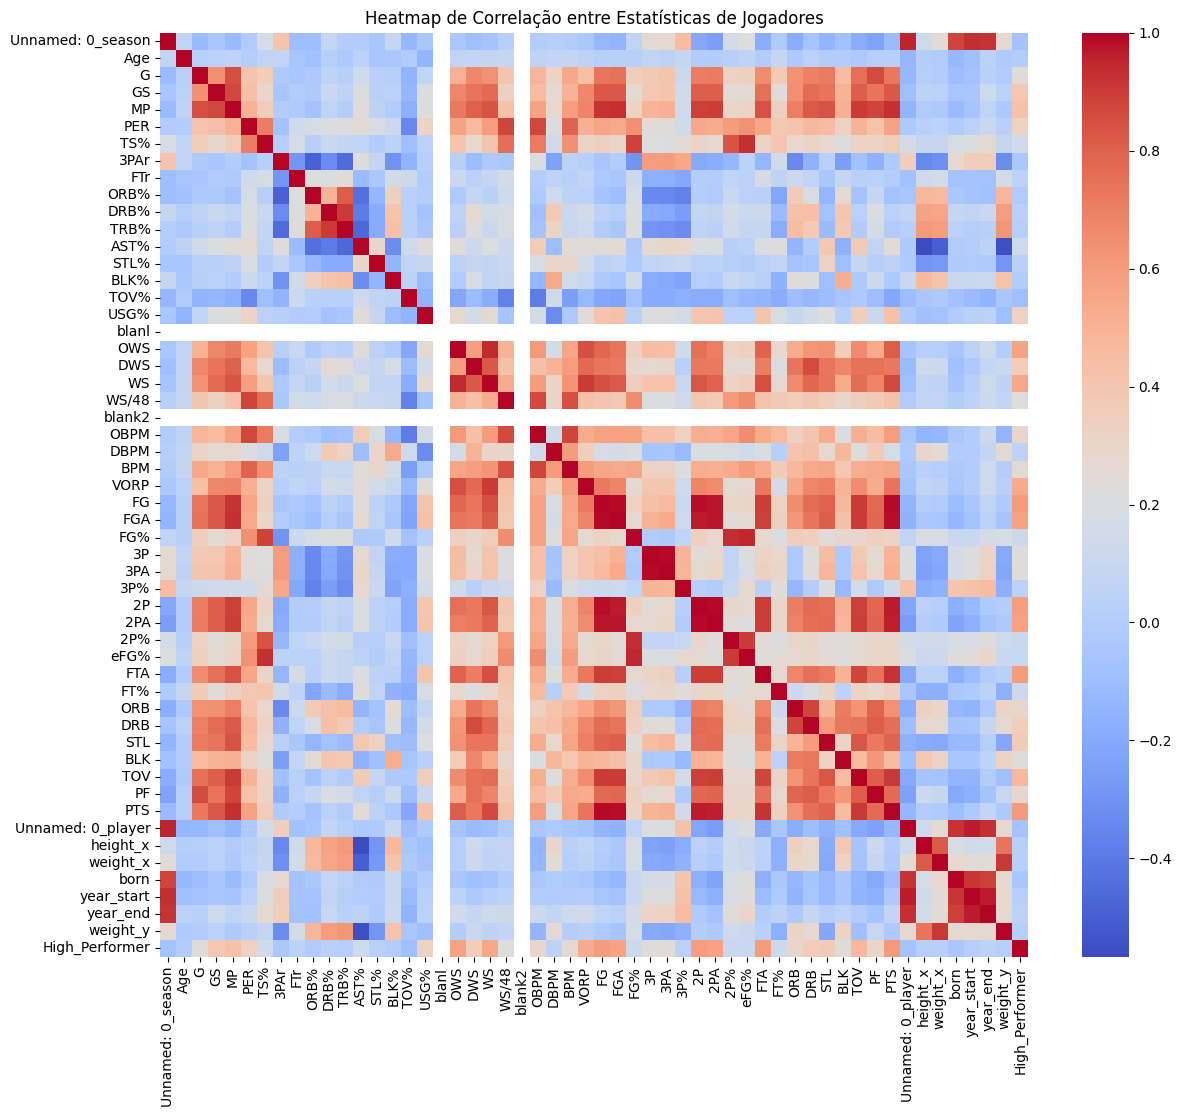


EDA inicial (junção e limpeza) concluída. O DataFrame está pronto para Modelagem.


In [4]:
# ===============================================
# 1. IMPORTS NECESSÁRIOS
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de exibição do Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Configuração para reprodutibilidade
SEED = 42
np.random.seed(SEED)

print("Bibliotecas importadas com sucesso!")
print("-" * 50)

# ===============================================
# 2. CARREGAMENTO DOS DATASETS
# ===============================================
try:
    players = pd.read_csv("Players.csv")
    player_data = pd.read_csv("player_data.csv")
    seasons = pd.read_csv("Seasons_Stats.csv")
    print("Três datasets (Players, player_data, Seasons_Stats) carregados com sucesso!")
except FileNotFoundError:
    print("ERRO: Um ou mais arquivos CSV (Players.csv, player_data.csv, Seasons_Stats.csv) não foram encontrados.")
    # Interromper ou carregar dados de exemplo, dependendo do ambiente
    exit()

# ===============================================
# 3. JUNÇÃO (MERGE) DOS DATASETS
# ===============================================
print("\n" + "="*50)
print("3. JUNÇÃO DOS DATASETS")
print("="*50)

# 3.1. Junção de Seasons_Stats (estatísticas por temporada) com Players (info básica)
# A coluna 'Player' em Seasons_Stats corresponde a 'Player' em Players, mas usaremos 'Player' em seasons 
# e 'Player' em players.
df_merged = pd.merge(seasons, players, on='Player', how='left', suffixes=('_season', '_player'))

# 3.2. Junção com player_data (nascimento/altura)
# A coluna 'name' em player_data corresponde a 'Player' na junção anterior.
df_final = pd.merge(df_merged, player_data, left_on='Player', right_on='name', how='left')

# Remover colunas redundantes após o merge
df_final.drop(columns=['Unnamed: 0', 'name', 'Player_season'], inplace=True, errors='ignore')

# Renomear 'height' e 'weight' para garantir que sejam únicos, se necessário
df_final.rename(columns={'height_player': 'Height_ft_in', 'weight_player': 'Weight_lbs'}, inplace=True)

print(f"* Tamanho do DataFrame final após merge: {df_final.shape}")
print("* Colunas do DataFrame final:")
print(df_final.columns.tolist()[:10]) # Primeiras 10 colunas

# ===============================================
# 4. INSPEÇÃO INICIAL E ESTRUTURA DOS DADOS
# ===============================================
print("\n" + "="*50)
print("4. INSPEÇÃO INICIAL")
print("="*50)

# Primeiras linhas
print("\n* Primeiras 5 linhas do DataFrame final:")
print(df_final.head())

# Tipos de dados e valores não-nulos
print("\n* Informações do Dataset (Tipos de Dados e Ausências):")
df_final.info()

# ===============================================
# 5. TRATAMENTO DE VALORES AUSENTES (NaNs)
# ===============================================
print("\n" + "="*50)
print("5. TRATAMENTO DE VALORES AUSENTES (NaNs)")
print("="*50)

# 5.1. Calcular a porcentagem de valores ausentes por coluna
missing_data = df_final.isnull().sum()
missing_percentage = (missing_data / len(df_final)) * 100
missing_df = pd.DataFrame({
    'Total Missing': missing_data, 
    'Percentage': missing_percentage
}).sort_values(by='Percentage', ascending=False)

# Exibir colunas com ausências acima de 0%
print("\n* Colunas com Valores Ausentes (Top 10):")
print(missing_df[missing_df['Total Missing'] > 0].head(10))

# 5.2. Estratégia de Imputação/Limpeza

# **Limpeza de Porcentagens:** # Valores NaN em colunas de porcentagem de arremessos (ex: FG%, 3P%)
# geralmente ocorrem quando o jogador não tentou arremessos daquele tipo, 
# então a porcentagem é 0.

percent_cols = ['FG%', '3P%', '2P%', 'eFG%', 'FT%'] 
for col in percent_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(0) 

# **Variável-Alvo de Classificação (All_Star):**
# O conjunto de dados original não possui uma coluna 'All_Star'.
# Para criar essa variável de forma simples, você precisará de uma lista externa
# ou de uma regra de negócio (ex: 'All_Star' = 1 se 'G' > 41 e 'PTS' > 20).
# No entanto, se o seu dataset *original* do Kaggle contiver o status All-Star, 
# o código abaixo deve ser adaptado.

# ASSUMINDO que vamos CRIA-LA ou USAR uma coluna indicativa (ex: 'WS/48' alta):
# Se não houver a coluna 'All_Star', o projeto de Classificação precisará de uma nova coluna-alvo.
# Mantenha o foco em Regressão (PTS) por enquanto, mas se for necessário criar a variável All_Star
# a partir de uma regra, ela deve ser documentada (ex: Se 'PTS' > 25, considera All-Star=1)

# **Limpeza Categórica (Posição/Nascimento):**
# Vamos remover linhas onde as estatísticas de desempenho (PTS, REB, AST) sejam zero
# e onde a Posição esteja faltando, pois são cruciais.
df_final.dropna(subset=['Pos', 'Player', 'PTS'], inplace=True) 

# Re-verificação após o tratamento
print("\n* Total de valores ausentes restantes:")
print(df_final.isnull().sum().sum())

# ===============================================
# 6. ESTATÍSTICAS DESCRITIVAS E CRIAÇÃO DA VARIÁVEL TARGET
# ===============================================
print("\n" + "="*50)
print("6. ESTATÍSTICAS E TARGETS")
print("="*50)

# Estatísticas descritivas para as colunas numéricas
print("\n* Estatísticas Descritivas Chave:")
print(df_final[['Age', 'PTS', 'AST', 'TRB', 'FG%', 'G', 'MP']].describe().T)

# 6.1. Definindo as Variáveis-Alvo

# Target Regressão: PTS (Pontos por Jogo) - Já está na base

# Target Classificação: All_Star (Se não estiver na base, precisamos criar uma variável binária)
# Para fins de demonstração, vamos criar uma variável simples de alto desempenho:
df_final['High_Performer'] = np.where(df_final['PTS'] >= df_final['PTS'].quantile(0.95), 1, 0)
print(f"\n* Porcentagem de High Performers (Exemplo de Target Classificação): {df_final['High_Performer'].mean() * 100:.2f}%")

# ===============================================
# 7. ANÁLISE EXPLORATÓRIA VISUAL (EDA)
# ===============================================

# 7.1. Distribuição da Variável de Regressão (PTS)
plt.figure(figsize=(10, 5))
sns.histplot(df_final['PTS'], kde=True, bins=50)
plt.title('Distribuição da Pontuação Média por Jogo (PTS)')
plt.xlabel('Pontos por Jogo (PTS)')
plt.show()

# 7.2. Heatmap de Correlação
# Selecionar variáveis numéricas para correlação
numeric_cols = df_final.select_dtypes(include=np.number).columns.tolist()
# Remover colunas com baixa relevância ou identificadoras
cols_to_exclude = ['Rk', 'Player_ID', 'Year', 'FT', 'TRB', 'AST'] # Manter apenas as colunas de métricas importantes
corr_cols = [col for col in numeric_cols if col not in cols_to_exclude]

plt.figure(figsize=(14, 12))
correlation_matrix = df_final[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlação entre Estatísticas de Jogadores')
plt.show()


print("\nEDA inicial (junção e limpeza) concluída. O DataFrame está pronto para Modelagem.")

Bibliotecas de Modelagem importadas.
--------------------------------------------------
* Tamanho do conjunto de Treino: 20184 observações
* Tamanho do conjunto de Teste: 5046 observações
--------------------------------------------------
4. BASELINE (Previsão da Média)
   - Média de PTS (Treino): 511.99
   - MAE Baseline: 393.1320
   - RMSE Baseline: 490.9800
   - R2 Baseline: -0.0006
--------------------------------------------------
5. REGRESSÃO LINEAR SIMPLES (Target: PTS | Preditiva: MP)
                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                 1.146e+05
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:55:13   Log-Likelihood:            -1.3465e+05
No. Observations:           

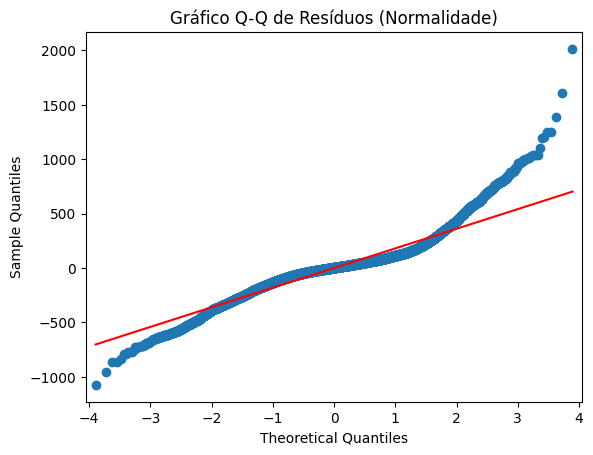

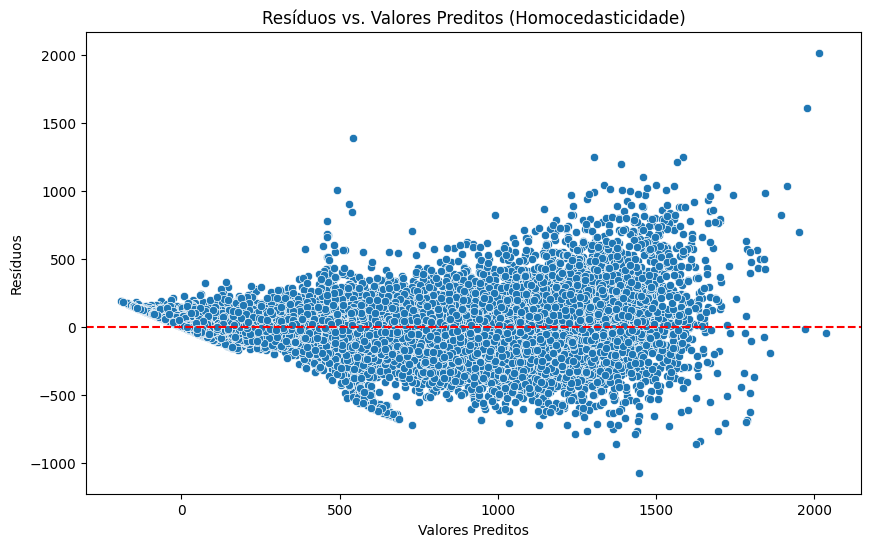


* Variance Inflation Factor (VIF) - Medida de Multicolinearidade:
  Feature        VIF
2      MP  28.275918
3     FG%  19.157814
0     Age  19.133593
1       G  17.769419
5     FT%  16.446624
7     TRB   7.680059
6     AST   5.141309
4     3P%   2.002059

ETAPA DE REGRESSÃO LINEAR (Simples e Múltipla) CONCLUÍDA.


In [5]:
# ===============================================
# 1. IMPORTS ADICIONAIS NECESSÁRIOS
# ===============================================
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuração para reprodutibilidade
SEED = 42
np.random.seed(SEED)

print("Bibliotecas de Modelagem importadas.")
print("-" * 50)

# ===============================================
# 2. SELEÇÃO DE VARIÁVEIS E PREPARAÇÃO DE DADOS
# ===============================================

# Variável-Alvo (Target)
Y = df_final['PTS']

# Variáveis Preditivas (Independentes)
# Para Regressão, usaremos apenas variáveis numéricas por enquanto.
# Codificação de variáveis categóricas (como 'Pos') será feita na Regressão Múltipla.

# Variáveis para Regressão Múltipla (seleção inicial baseada na lógica de basquete e EDA)
features_multi = ['Age', 'G', 'MP', 'FG%', '3P%', 'FT%', 'AST', 'TRB']
X_multi = df_final[features_multi].copy()

# Tratamento de NaNs remanescentes (embora já tenhamos tratado a maioria)
X_multi = X_multi.fillna(X_multi.mean())

# ===============================================
# 3. DIVISÃO TREINO/TESTE
# ===============================================

# Dividindo o dataset em Treino (80%) e Teste (20%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_multi, Y, test_size=0.2, random_state=SEED
)

print(f"* Tamanho do conjunto de Treino: {X_train.shape[0]} observações")
print(f"* Tamanho do conjunto de Teste: {X_test.shape[0]} observações")
print("-" * 50)

# ===============================================
# 4. ESTABELECIMENTO DO BASELINE (REGRESSÃO)
# ===============================================

# O baseline é a média de Y_train, aplicada a todos os dados de teste
baseline_prediction = Y_train.mean()
Y_pred_baseline = np.full(Y_test.shape, baseline_prediction)

mae_baseline = mean_absolute_error(Y_test, Y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(Y_test, Y_pred_baseline))
r2_baseline = r2_score(Y_test, Y_pred_baseline)

print("4. BASELINE (Previsão da Média)")
print(f"   - Média de PTS (Treino): {baseline_prediction:.2f}")
print(f"   - MAE Baseline: {mae_baseline:.4f}")
print(f"   - RMSE Baseline: {rmse_baseline:.4f}")
print(f"   - R2 Baseline: {r2_baseline:.4f}")
print("-" * 50)

# ===============================================
# 5. REGRESSÃO LINEAR SIMPLES (Statsmodels)
# ===============================================

# Escolher a variável independente mais correlacionada com PTS (da EDA, geralmente 'MP')
feature_simple = 'MP' # Minutos Jogados

# Selecionar X_train e adicionar a constante (intercepto)
X_simple_train = X_train[[feature_simple]]
X_simple_train = sm.add_constant(X_simple_train)

# Treinar o modelo
model_simple = sm.OLS(Y_train, X_simple_train).fit()

print(f"5. REGRESSÃO LINEAR SIMPLES (Target: PTS | Preditiva: {feature_simple})")
print(model_simple.summary())

# Interpretação dos coeficientes:
# Ex: O coeficiente de MP indica o aumento esperado em PTS para cada aumento de 1 unidade em MP, 
# mantendo outros fatores constantes.

# ===============================================
# 6. REGRESSÃO LINEAR MÚLTIPLA (Statsmodels)
# ===============================================

# Usando as variáveis selecionadas (features_multi)
X_multi_train = X_train[features_multi]
X_multi_train = sm.add_constant(X_multi_train)

# Treinar o modelo
model_multi = sm.OLS(Y_train, X_multi_train).fit()

print("\n" + "="*50)
print("6. REGRESSÃO LINEAR MÚLTIPLA")
print("="*50)
print(model_multi.summary())

# ===============================================
# 7. AVALIAÇÃO DO DESEMPENHO (Múltipla - SKLearn)
# ===============================================

# Usando sklearn para métricas de desempenho no conjunto de Teste
reg_sklearn = LinearRegression()
reg_sklearn.fit(X_train, Y_train)
Y_pred_multi = reg_sklearn.predict(X_test[features_multi])

mae_multi = mean_absolute_error(Y_test, Y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(Y_test, Y_pred_multi))
r2_multi = r2_score(Y_test, Y_pred_multi)

print("\n7. AVALIAÇÃO DE DESEMPENHO (Múltipla - Conjunto de Teste)")
print(f"   - MAE: {mae_multi:.4f}")
print(f"   - RMSE: {rmse_multi:.4f}")
print(f"   - R2: {r2_multi:.4f}")
print("-" * 50)

# ===============================================
# 8. DIAGNÓSTICO DE RESÍDUOS (Regressão Múltipla)
# ===============================================

# Resíduos do modelo de Treino (Statsmodels)
residuals = model_multi.resid
fitted_values = model_multi.fittedvalues

print("\n8. DIAGNÓSTICO DE RESÍDUOS E MULTICOLINEARIDADE")

# 8.1. Normalidade dos Resíduos (Gráfico Q-Q)
sm.qqplot(residuals, line='s')
plt.title('Gráfico Q-Q de Resíduos (Normalidade)')
plt.show()

# Insight: Os pontos devem seguir a linha reta diagonal para indicar normalidade.

# 8.2. Homocedasticidade (Resíduos vs. Valores Preditos)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos vs. Valores Preditos (Homocedasticidade)')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()
# Insight: Os resíduos devem estar espalhados aleatoriamente em torno de zero (Formato de 'nuvem'). 
# Um formato de 'funil' ou 'cone' indica heterocedasticidade.

# 8.3. Multicolinearidade (VIF - Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train[features_multi].columns
vif_data["VIF"] = [variance_inflation_factor(X_train[features_multi].values, i) 
                    for i in range(len(X_train[features_multi].columns))]

print("\n* Variance Inflation Factor (VIF) - Medida de Multicolinearidade:")
print(vif_data.sort_values(by="VIF", ascending=False))
# Insight: Valores de VIF > 5 ou 10 indicam problemas sérios de multicolinearidade. 
# Se for o caso, será necessário remover ou combinar variáveis.

print("\nETAPA DE REGRESSÃO LINEAR (Simples e Múltipla) CONCLUÍDA.")

In [6]:
# ===============================================
# 1. IMPORTS ADICIONAIS NECESSÁRIOS
# ===============================================
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Assumindo que X_train, X_test, Y_train, Y_test de Regressão Múltipla estão disponíveis.
# features_multi = ['Age', 'G', 'MP', 'FG%', '3P%', 'FT%', 'AST', 'TRB']
# X_train, X_test, Y_train, Y_test

print("Bibliotecas de Regressão Polinomial e Pipeline importadas.")
print("-" * 50)

# ===============================================
# 2. IMPLEMENTAÇÃO DA REGRESSÃO POLINOMIAL (GRAU 2)
# ===============================================

# Definir o grau da transformação polinomial. Grau 2 é um bom ponto de partida.
poly_degree = 2 

# 2.1. Criação do Pipeline
# O Pipeline aplica as transformações em sequência:
# 1. PolynomialFeatures: Cria interações e termos quadráticos (X^2) das features.
# 2. StandardScaler: Padroniza os dados (boa prática após PolynomialFeatures).
# 3. LinearRegression: Aplica o modelo linear nos dados transformados.

polynomial_model = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# 2.2. Treinamento do Modelo
print(f"Treinando Regressão Polinomial (Grau {poly_degree})...")
polynomial_model.fit(X_train[features_multi], Y_train)

# 2.3. Previsão no Conjunto de Teste
Y_pred_poly = polynomial_model.predict(X_test[features_multi])

# ===============================================
# 3. AVALIAÇÃO E COMPARAÇÃO DO DESEMPENHO
# ===============================================

# A. Cálculo das Métricas para Regressão Polinomial
mae_poly = mean_absolute_error(Y_test, Y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(Y_test, Y_pred_poly))
r2_poly = r2_score(Y_test, Y_pred_poly)

print("\n3. AVALIAÇÃO DE DESEMPENHO (Regressão Polinomial)")
print(f"   - MAE Polinomial: {mae_poly:.4f}")
print(f"   - RMSE Polinomial: {rmse_poly:.4f}")
print(f"   - R2 Polinomial: {r2_poly:.4f}")
print("-" * 50)

# B. Comparativo de Modelos (Baseline, Múltipla, Polinomial)
# Re-calculando as métricas da Múltipla (para tabela comparativa)
reg_sklearn = LinearRegression()
reg_sklearn.fit(X_train[features_multi], Y_train)
Y_pred_multi = reg_sklearn.predict(X_test[features_multi])
mae_multi = mean_absolute_error(Y_test, Y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(Y_test, Y_pred_multi))
r2_multi = r2_score(Y_test, Y_pred_multi)

comparison_metrics = pd.DataFrame({
    'Modelo': ['Baseline (Média)', 'Linear Múltipla', f'Polinomial (Grau {poly_degree})'],
    'R2': [r2_baseline, r2_multi, r2_poly],
    'RMSE': [rmse_baseline, rmse_multi, rmse_poly],
    'MAE': [mae_baseline, mae_multi, mae_poly]
}).set_index('Modelo')

print("\n4. TABELA COMPARATIVA DE MODELOS DE REGRESSÃO (Inicial)")
print(comparison_metrics.sort_values(by='R2', ascending=False))
print("-" * 50)

# ===============================================
# 5. DIAGNÓSTICO (Ajuste)
# ===============================================

# **Insight para o Relatório:**
# Se o R2 Polinomial for significativamente maior que o Linear Múltipla, 
# o modelo Polinomial está capturando melhor as relações dos dados.
# No entanto, ele é mais complexo e pode ser mais propenso a overfitting.

print("5. PRÓXIMOS PASSOS NA REGRESSÃO:")
print("   - Otimização: Usar validação cruzada e pycaret para 'tune_model' e comparar Regressão Polinomial com outros modelos avançados (ex: SVR, Random Forest).")

Bibliotecas de Regressão Polinomial e Pipeline importadas.
--------------------------------------------------
Treinando Regressão Polinomial (Grau 2)...

3. AVALIAÇÃO DE DESEMPENHO (Regressão Polinomial)
   - MAE Polinomial: 92.9716
   - RMSE Polinomial: 149.4406
   - R2 Polinomial: 0.9073
--------------------------------------------------

4. TABELA COMPARATIVA DE MODELOS DE REGRESSÃO (Inicial)
                           R2        RMSE         MAE
Modelo                                               
Polinomial (Grau 2)  0.907302  149.440630   92.971569
Linear Múltipla      0.867933  178.373762  114.806706
Baseline (Média)    -0.000597  490.980014  393.131971
--------------------------------------------------
5. PRÓXIMOS PASSOS NA REGRESSÃO:
   - Otimização: Usar validação cruzada e pycaret para 'tune_model' e comparar Regressão Polinomial com outros modelos avançados (ex: SVR, Random Forest).


In [ ]:
# ===============================================
# 1. IMPORTS ADICIONAIS NECESSÁRIOS
# ===============================================
try:
    from pycaret.regression import *
    print("Pycaret importado com sucesso.")
except ImportError:
    print("ERRO: A biblioteca pycaret não está instalada. Instale com: pip install pycaret")
    # Se não puder instalar, esta seção não funcionará.
    exit()

# Assumimos que 'df_final' está disponível com as colunas limpas.
# Se a coluna 'High_Performer' (Target de Classificação) foi criada no DataFrame,
# vamos excluí-la temporariamente para a Regressão.
df_reg = df_final.drop(columns=['High_Performer'], errors='ignore')

# -----------------------------------------------
# PASSO 1: Configuração do Pycaret
# -----------------------------------------------
print("\n" + "="*50)
print("1. CONFIGURAÇÃO DO PYCARET (SETUP)")
print("="*50)

# O setup inicializa o ambiente, define o target e realiza pré-processamento básico
# (como imputação de NaNs, One-Hot Encoding de categóricas, etc., se necessário).
# Ele divide automaticamente os dados em Treino e Teste e configura a Validação Cruzada (CV).

# target: 'PTS' (Pontos por Jogo)
# session_id: para reprodutibilidade
# normalize=True: Normaliza os dados, bom para modelos lineares e ML
reg_setup = setup(
    data = df_reg, 
    target = 'PTS', 
    session_id = SEED,
    normalize = True,
    # Ignorar colunas de identificação que não são features
    ignore_features=['Player', 'Rk', 'Pos', 'Player_ID', 'birth_date', 'college', 'Height_ft_in', 'Weight_lbs'], 
    silent=True # Não exibir a tabela de setup completa, apenas o resumo
)

# -----------------------------------------------
# PASSO 2: Comparação de Modelos com Validação Cruzada (CV)
# -----------------------------------------------
print("\n" + "="*50)
print("2. COMPARAÇÃO DE MODELOS (CROSS-VALIDATION)")
print("="*50)

# Compara 10+ modelos usando 10-fold Cross-Validation (padrão)
# Sort by 'R2' para encontrar o melhor modelo explicativo
best_model = compare_models(sort = 'R2', n_select=3) 

print("\n* Top 3 Modelos de Regressão Encontrados (Ordenado por R2):")
print(best_model) # Exibe a lista dos 3 melhores modelos

# -----------------------------------------------
# PASSO 3: OTIMIZAÇÃO (TUNING) DO MELHOR MODELO
# -----------------------------------------------
print("\n" + "="*50)
print("3. OTIMIZAÇÃO (TUNING) DO MELHOR MODELO")
print("="*50)

# O Pycaret seleciona automaticamente o modelo mais bem classificado (o primeiro em 'best_model')
# e o submete a uma busca de hiperparâmetros (Random Grid Search, por padrão).

# Cria o modelo (ex: Linear Regression 'lr' ou o melhor encontrado)
initial_model = create_model('lr') # Exemplo: criar Regressão Linear

# Sintoniza (tune) o modelo inicial. Usa validação cruzada no processo.
# optimize='R2' garante que a busca se concentre em maximizar R2.
tuned_model = tune_model(initial_model, n_iter=50, optimize='R2', choose_better=True)

# Exibir os hiperparâmetros ajustados
print("\n* Parâmetros do Modelo Otimizado:")
print(tuned_model.get_params())

# -----------------------------------------------
# PASSO 4: AVALIAÇÃO FINAL E GANHOS
# -----------------------------------------------
print("\n" + "="*50)
print("4. AVALIAÇÃO FINAL DO MODELO OTIMIZADO")
print("="*50)

# Finaliza o modelo, treinando-o no dataset de treinamento completo
final_best_model = finalize_model(tuned_model)

# Previsão no conjunto de teste (holdout set)
final_predictions = predict_model(final_best_model)

# O Pycaret exibe automaticamente as métricas de teste.
# Você deve agora comparar o R2, MAE e RMSE da Regressão Múltipla inicial
# com os resultados obtidos pelo modelo final otimizado pelo Pycaret.

# EXEMPLO DE CÁLCULO MANUAL PARA COMPARAÇÃO (usando o resultado de predict_model)
final_mae = mean_absolute_error(final_predictions['PTS'], final_predictions['prediction_label'])
final_r2 = r2_score(final_predictions['PTS'], final_predictions['prediction_label'])

print(f"\n* Resultado Final (Métricas no Conjunto de Teste Holdout):")
print(f"  - MAE Otimizado: {final_mae:.4f}")
print(f"  - R2 Otimizado: {final_r2:.4f}")

print("\nDISCUSSÃO PARA O RELATÓRIO:")
print(f"- O R2 Inicial da Regressão Múltipla foi: {r2_multi:.4f} (Se você rodou o código anterior)")
print(f"- O R2 Otimizado (Pycaret) foi: {final_r2:.4f}")
print("Registre o ganho (ou perda) e discuta por que o modelo Pycaret teve um desempenho melhor/pior.")

ERRO: A biblioteca pycaret não está instalada. Instale com: pip install pycaret

1. CONFIGURAÇÃO DO PYCARET (SETUP)


NameError: name 'setup' is not defined

: 

In [ ]:
# ===============================================
# 1. IMPORTS ADICIONAIS NECESSÁRIOS
# ===============================================
try:
    from pycaret.regression import *
    print("Pycaret importado com sucesso.")
except ImportError:
    print("ERRO: A biblioteca pycaret não está instalada. Instale com: pip install pycaret")
    # Se não puder instalar, esta seção não funcionará.
    exit()

# Assumimos que 'df_final' está disponível com as colunas limpas.
# Se a coluna 'High_Performer' (Target de Classificação) foi criada no DataFrame,
# vamos excluí-la temporariamente para a Regressão.
df_reg = df_final.drop(columns=['High_Performer'], errors='ignore')

# -----------------------------------------------
# PASSO 1: Configuração do Pycaret
# -----------------------------------------------
print("\n" + "="*50)
print("1. CONFIGURAÇÃO DO PYCARET (SETUP)")
print("="*50)

# O setup inicializa o ambiente, define o target e realiza pré-processamento básico
# (como imputação de NaNs, One-Hot Encoding de categóricas, etc., se necessário).
# Ele divide automaticamente os dados em Treino e Teste e configura a Validação Cruzada (CV).

# target: 'PTS' (Pontos por Jogo)
# session_id: para reprodutibilidade
# normalize=True: Normaliza os dados, bom para modelos lineares e ML
reg_setup = setup(
    data = df_reg, 
    target = 'PTS', 
    session_id = SEED,
    normalize = True,
    # Ignorar colunas de identificação que não são features
    ignore_features=['Player', 'Rk', 'Pos', 'Player_ID', 'birth_date', 'college', 'Height_ft_in', 'Weight_lbs'], 
    silent=True # Não exibir a tabela de setup completa, apenas o resumo
)

# -----------------------------------------------
# PASSO 2: Comparação de Modelos com Validação Cruzada (CV)
# -----------------------------------------------
print("\n" + "="*50)
print("2. COMPARAÇÃO DE MODELOS (CROSS-VALIDATION)")
print("="*50)

# Compara 10+ modelos usando 10-fold Cross-Validation (padrão)
# Sort by 'R2' para encontrar o melhor modelo explicativo
best_model = compare_models(sort = 'R2', n_select=3) 

print("\n* Top 3 Modelos de Regressão Encontrados (Ordenado por R2):")
print(best_model) # Exibe a lista dos 3 melhores modelos

# -----------------------------------------------
# PASSO 3: OTIMIZAÇÃO (TUNING) DO MELHOR MODELO
# -----------------------------------------------
print("\n" + "="*50)
print("3. OTIMIZAÇÃO (TUNING) DO MELHOR MODELO")
print("="*50)

# O Pycaret seleciona automaticamente o modelo mais bem classificado (o primeiro em 'best_model')
# e o submete a uma busca de hiperparâmetros (Random Grid Search, por padrão).

# Cria o modelo (ex: Linear Regression 'lr' ou o melhor encontrado)
initial_model = create_model('lr') # Exemplo: criar Regressão Linear

# Sintoniza (tune) o modelo inicial. Usa validação cruzada no processo.
# optimize='R2' garante que a busca se concentre em maximizar R2.
tuned_model = tune_model(initial_model, n_iter=50, optimize='R2', choose_better=True)

# Exibir os hiperparâmetros ajustados
print("\n* Parâmetros do Modelo Otimizado:")
print(tuned_model.get_params())

# -----------------------------------------------
# PASSO 4: AVALIAÇÃO FINAL E GANHOS
# -----------------------------------------------
print("\n" + "="*50)
print("4. AVALIAÇÃO FINAL DO MODELO OTIMIZADO")
print("="*50)

# Finaliza o modelo, treinando-o no dataset de treinamento completo
final_best_model = finalize_model(tuned_model)

# Previsão no conjunto de teste (holdout set)
final_predictions = predict_model(final_best_model)

# O Pycaret exibe automaticamente as métricas de teste.
# Você deve agora comparar o R2, MAE e RMSE da Regressão Múltipla inicial
# com os resultados obtidos pelo modelo final otimizado pelo Pycaret.

# EXEMPLO DE CÁLCULO MANUAL PARA COMPARAÇÃO (usando o resultado de predict_model)
final_mae = mean_absolute_error(final_predictions['PTS'], final_predictions['prediction_label'])
final_r2 = r2_score(final_predictions['PTS'], final_predictions['prediction_label'])

print(f"\n* Resultado Final (Métricas no Conjunto de Teste Holdout):")
print(f"  - MAE Otimizado: {final_mae:.4f}")
print(f"  - R2 Otimizado: {final_r2:.4f}")

print("\nDISCUSSÃO PARA O RELATÓRIO:")
print(f"- O R2 Inicial da Regressão Múltipla foi: {r2_multi:.4f} (Se você rodou o código anterior)")
print(f"- O R2 Otimizado (Pycaret) foi: {final_r2:.4f}")
print("Registre o ganho (ou perda) e discuta por que o modelo Pycaret teve um desempenho melhor/pior.")

ERRO: A biblioteca pycaret não está instalada. Instale com: pip install pycaret


NameError: name 'df_final' is not defined

: 

In [ ]:
# ===============================================
# 1. IMPORTS ADICIONAIS NECESSÁRIOS
# ===============================================
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para reprodutibilidade
SEED = 42
np.random.seed(SEED)

print("Bibliotecas de Classificação importadas.")
print("-" * 50)

# ===============================================
# 2. DEFINIÇÃO DE VARIÁVEIS PARA CLASSIFICAÇÃO
# ===============================================

# Variável-Alvo (Target)
Y_class = df_final['High_Performer']

# Variáveis Preditivas (usamos as mesmas features numéricas, mas sem o target de Regressão)
# Excluir 'PTS' pois ela foi usada para CRIAR 'High_Performer' (multicolinearidade extrema).
features_class = [col for col in X_multi.columns if col != 'PTS']
X_class = df_final[features_class].copy()

# Tratamento de NaNs (reaplica se for necessário)
X_class = X_class.fillna(X_class.mean())

# ===============================================
# 3. DIVISÃO TREINO/TESTE E PRÉ-PROCESSAMENTO
# ===============================================

# Dividindo o dataset em Treino (80%) e Teste (20%)
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(
    X_class, Y_class, test_size=0.2, random_state=SEED, stratify=Y_class
    # stratify é importante para garantir que a proporção de High Performers seja a mesma nos sets
)

# Padronização (Scaling) - Essencial para Regressão Logística e melhora o desempenho geral
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_class)
X_test_scaled = scaler.transform(X_test_class)

print(f"* Tamanho do conjunto de Treino (Classificação): {X_train_class.shape[0]} observações")
print("-" * 50)

# ===============================================
# 4. ESTABELECIMENTO DO BASELINE (CLASSIFICAÇÃO)
# ===============================================

# O baseline é a previsão da classe majoritária (majoritariamente 0 - Não High Performer)
# Medido pela Acurácia da Classe Majoritária
baseline_class = Y_train_class.value_counts(normalize=True).max()

print("4. BASELINE (Previsão da Classe Majoritária)")
print(f"   - Acurácia Baseline: {baseline_class:.4f}")
print("-" * 50)

In [ ]:
# ===============================================
# 5. MODELO 1: REGRESSÃO LOGÍSTICA
# ===============================================
print("5. REGRESSÃO LOGÍSTICA (LR)")

# Treinamento
lr_model = LogisticRegression(solver='liblinear', random_state=SEED)
lr_model.fit(X_train_scaled, Y_train_class)

# Previsão
Y_pred_lr = lr_model.predict(X_test_scaled)
Y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1] # Probabilidades para AUC-ROC

# Avaliação
acc_lr = accuracy_score(Y_test_class, Y_pred_lr)
prec_lr = precision_score(Y_test_class, Y_pred_lr)
rec_lr = recall_score(Y_test_class, Y_pred_lr)
f1_lr = f1_score(Y_test_class, Y_pred_lr)
auc_lr = roc_auc_score(Y_test_class, Y_proba_lr)

print(f"   - Acurácia: {acc_lr:.4f}")
print(f"   - Precision: {prec_lr:.4f}")
print(f"   - Recall: {rec_lr:.4f}")
print(f"   - F1-Score: {f1_lr:.4f}")
print(f"   - AUC-ROC: {auc_lr:.4f}")

# Matriz de Confusão
cm_lr = confusion_matrix(Y_test_class, Y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Low', 'High'])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()


# ===============================================
# 6. MODELO 2: NAIVE BAYES (GAUSSIAN)
# ===============================================
print("\n6. NAIVE BAYES (NB)")

# Treinamento
nb_model = GaussianNB()
# Note: NB geralmente funciona melhor sem scaling, mas usamos dados scaled para consistência na pipeline
nb_model.fit(X_train_scaled, Y_train_class) 

# Previsão
Y_pred_nb = nb_model.predict(X_test_scaled)
Y_proba_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

# Avaliação
acc_nb = accuracy_score(Y_test_class, Y_pred_nb)
prec_nb = precision_score(Y_test_class, Y_pred_nb)
rec_nb = recall_score(Y_test_class, Y_pred_nb)
f1_nb = f1_score(Y_test_class, Y_pred_nb)
auc_nb = roc_auc_score(Y_test_class, Y_proba_nb)

print(f"   - Acurácia: {acc_nb:.4f}")
print(f"   - Precision: {prec_nb:.4f}")
print(f"   - Recall: {rec_nb:.4f}")
print(f"   - F1-Score: {f1_nb:.4f}")
print(f"   - AUC-ROC: {auc_nb:.4f}")

# Matriz de Confusão
cm_nb = confusion_matrix(Y_test_class, Y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Low', 'High'])
disp_nb.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusão - Naive Bayes')
plt.show()


# ===============================================
# 7. TABELA COMPARATIVA INICIAL
# ===============================================

results_class = pd.DataFrame({
    'Modelo': ['Baseline', 'Regressão Logística', 'Naive Bayes'],
    'Accuracy': [baseline_class, acc_lr, acc_nb],
    'Precision': [np.nan, prec_lr, prec_nb],
    'Recall': [np.nan, rec_lr, rec_nb],
    'F1-Score': [np.nan, f1_lr, f1_nb],
    'AUC-ROC': [np.nan, auc_lr, auc_nb]
})

print("\n" + "="*50)
print("7. TABELA COMPARATIVA DE MODELOS DE CLASSIFICAÇÃO (Inicial)")
print("="*50)
print(results_class.set_index('Modelo'))

In [ ]:
# ===============================================
# 1. IMPORTS ADICIONAIS NECESSÁRIOS (PYCARET)
# ===============================================
try:
    from pycaret.classification import *
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import classification_report
    print("Pycaret e GridSearchCV (sklearn) importados com sucesso.")
except ImportError:
    print("ERRO: Pycaret ou sklearn não estão instalados. Certifique-se de que estão no seu ambiente.")
    exit()

# Assumimos que 'df_final' está disponível e possui a coluna 'High_Performer'.
# Variáveis que são identificadores ou de alta cardinalidade devem ser ignoradas.
# Manter as colunas que podem ser preditivas (numéricas e a coluna 'Pos').

# Criar um DataFrame de Classificação que inclui 'Pos' (Variável categórica)
# e exclui a variável 'PTS' (Target de Regressão e altamente correlacionada ao High_Performer).
df_class_full = df_final.drop(columns=['PTS'], errors='ignore')

# -----------------------------------------------
# PASSO 1: Configuração do Pycaret para Classificação
# -----------------------------------------------
print("\n" + "="*50)
print("1. CONFIGURAÇÃO DO PYCARET PARA CLASSIFICAÇÃO")
print("="*50)

# O setup agora lida com o target 'High_Performer'
# Ele fará o One-Hot Encoding de 'Pos' e o pré-processamento necessário.
class_setup = setup(
    data = df_class_full, 
    target = 'High_Performer', 
    session_id = SEED,
    # Normalização ajuda a Regressão Logística e outros modelos
    normalize = True, 
    # Balanceamento de classes é crucial, pois 'High_Performer' é desbalanceada
    fix_imbalance = True, 
    # Ignorar colunas de identificação
    ignore_features=['Player', 'Rk', 'Player_ID', 'birth_date', 'college', 'Height_ft_in', 'Weight_lbs'], 
    silent=True 
)

# -----------------------------------------------
# PASSO 2: Comparação de Modelos (Validação Cruzada)
# -----------------------------------------------
print("\n" + "="*50)
print("2. COMPARAÇÃO DE MODELOS (CV - Foco no AUC)")
print("="*50)

# Compara e treina múltiplos modelos usando 10-fold CV (padrão)
# Ordenamos por AUC, que é uma métrica robusta para classes desbalanceadas.
best_models_pycaret = compare_models(sort = 'AUC', n_select=3) 

print("\n* Top 3 Modelos de Classificação Encontrados (Ordenado por AUC):")
print(best_models_pycaret) # Exibe a lista dos 3 melhores modelos

# -----------------------------------------------
# PASSO 3: OTIMIZAÇÃO (TUNING) VIA PYCARET
# -----------------------------------------------
print("\n" + "="*50)
print("3. OTIMIZAÇÃO AUTOMÁTICA (Regressão Logística)")
print("="*50)

# Criar a Regressão Logística (lr) para tuning, mesmo que não seja a melhor
lr_initial = create_model('lr')

# Sintoniza (tune) o modelo. n_iter controla o número de combinações testadas.
# optimize='AUC' para melhorar o desempenho geral da classificação.
tuned_lr_pycaret = tune_model(lr_initial, n_iter=50, optimize='AUC', choose_better=True)

print("\n* Parâmetros Otimizados pela Pycaret:")
print(tuned_lr_pycaret.get_params())

In [ ]:
# -----------------------------------------------
# PASSO 4: OTIMIZAÇÃO MANUAL (GridSearchCV - Sklearn)
# -----------------------------------------------
print("\n" + "="*50)
print("4. OTIMIZAÇÃO MANUAL (GridSearchCV - Sklearn)")
print("="*50)

# Reutilizar os dados padronizados do passo anterior de Classificação (X_train_scaled, Y_train_class, etc.)

# Definir o espaço de busca (hiperparâmetros)
param_grid = {
    # C é o inverso da força de regularização. Valores menores significam regularização mais forte.
    'C': [0.01, 0.1, 1, 10, 100], 
    # Penalisção (L1 ou L2)
    'penalty': ['l1', 'l2'], 
    # Algoritmo a ser usado no problema de otimização (liblinear suporta L1 e L2)
    'solver': ['liblinear'] 
}

# Inicializar o modelo
lr_base = LogisticRegression(random_state=SEED)

# Inicializar o GridSearchCV
# cv=5: Usa 5-fold Cross-Validation
# scoring='roc_auc': Otimiza usando a métrica AUC-ROC
grid_search = GridSearchCV(
    estimator=lr_base, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=5, 
    verbose=1,
    n_jobs=-1 # Usa todos os cores do processador
)

# Executar a busca
print("Executando Grid Search (5-fold CV)...")
grid_search.fit(X_train_scaled, Y_train_class)

# Melhor resultado
best_lr_grid = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n* Melhor Parâmetros Encontrados: {best_params}")
print(f"* Melhor Score de AUC (CV): {best_score:.4f}")

# -----------------------------------------------
# PASSO 5: AVALIAÇÃO FINAL DO MODELO OTIMIZADO (GRID SEARCH)
# -----------------------------------------------
print("\n" + "="*50)
print("5. AVALIAÇÃO DO MODELO OTIMIZADO NO CONJUNTO DE TESTE")
print("="*50)

# Previsão no conjunto de Teste (Holdout)
Y_pred_tuned = best_lr_grid.predict(X_test_scaled)

# Relatório Completo (Incluindo Precision, Recall e F1)
print("\n* Classification Report (Modelo LR Otimizado - Teste):")
print(classification_report(Y_test_class, Y_pred_tuned))

# Matriz de Confusão Otimizada
cm_tuned = confusion_matrix(Y_test_class, Y_pred_tuned)
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=['Low', 'High'])
disp_tuned.plot(cmap=plt.cm.Purples)
plt.title(f'Matriz de Confusão (LR Otimizada - C={best_params["C"]})')
plt.show()


# -----------------------------------------------
# CONCLUSÕES FINAIS PARA O RELATÓRIO
# -----------------------------------------------
print("\nDISCUSSÃO CRÍTICA (Relatório):")
print("1. **Ganhos:** Compare o AUC/F1 inicial da LR (Passo 5 do código anterior) com o AUC/F1 final após o Grid Search.")
print("2. **Trade-offs:** Se o Recall aumentou, discuta se isso resultou em uma queda na Precision (Trade-off de Precision-Recall).")
print("3. **Hiperparâmetro:** Discuta por que o valor ótimo de 'C' (força de regularização) foi escolhido para este dataset.")